# **1. Import Libraries**

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import pandas as pd
import cv2
import os
import io

# **2. Load Data**

**2-1. Connect To Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2-2. Unzip Dataset**

In [ ]:
from zipfile import ZipFile

with ZipFile('drive/MyDrive/brain_dataset.zip', 'r') as zipOb:
  zipOb.extractall('drive/MyDrive/brain_tumor_dataset')

**2-3. Loading and Resizing**

In [ ]:
# reading the dataset
rootPath = 'drive/MyDrive/brain_tumor_dataset'
trainFolder = rootPath+'/Training/'
testFolder = rootPath+'/Testing/'
labels = []

X_train = []
y_train = []

X_test = []
y_test = []


for folder in os.listdir(trainFolder):
    labels.append(folder)


for i in labels:
    folderPath = os.path.join(trainFolder,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(128, 128))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    folderPath = os.path.join(testFolder,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(128, 128))
        X_test.append(img)
        y_test.append(i)

**2-4. Converting Lists to NumPy Arrays**

In [ ]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

**2-5. Visualizing Random Samples from the Dataset**

In [ ]:
# Display sample images from the training set
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('Sample Images from the Brain Tumor Dataset', fontsize=16)

for i in range(2):
    for j in range(3):
        random_index = np.random.randint(0, len(X_train))
        axes[i, j].imshow(X_train[random_index])
        axes[i, j].set_title(f'Label: {y_train[random_index]}')
        axes[i, j].axis('off')

plt.show()

**2-6. Rescaling Pixel Values**

In [ ]:
# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

# **3. Data Preparation Pipeline: One-Hot Encoding, Splitting and Data Generation**

**3-1. One-Hot Encoding Labels**

In [ ]:
# One Hot Encoding
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**3-2. Shuffling and Splitting Data**

In [ ]:
# # Let's shuffle the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**3-3. Checking Shapes of Training, Testing, and Validation Sets**

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 128, 128, 3) (4855, 4)
(1311, 128, 128, 3) (1311, 4)
(857, 128, 128, 3) (857, 4)


**3-4. Creating Training Data Generator**

*   **Rotation:** Small rotations can help the model become more invariant to the orientation of the brain within the image. However, large rotations should be avoided to maintain the anatomical correctness.
*   **Zooming:** Zooming in and out can simulate variations in image resolution and focus.
*   **Horizontal and Vertical Flips:** Mirroring the images horizontally and vertically can help the model generalize better.
*   **Shearing:** Applying a small amount of shearing can simulate changes in the angle of the MRI scan.

In [ ]:
train_datagen = ImageDataGenerator(
    fill_mode="nearest",
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)



train_datagenerator = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True
)

# **4. Network Architecture**

**4-1. InceptionV3 Architecture**
**(Transfer Learning)**

In [ ]:
import sys
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications import InceptionV3

# Load MobileNetV2 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model.trainable = False
# Create a custom top model
x = base_model.output
x = Flatten()(x)
# x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Combine the base model and top model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalization[0][0

- we freezes the weights of the base model to prevent them from being updated during training.
- The base model's output is flattened, followed by a Dense layer with 128 units and ReLU activation.
- A Dropout layer with a dropout rate of 0.3 is added for regularization.
- The final layer is a Dense layer with 4 units (for 4 classes) and softmax activation.
- The model is compiled using the Adam optimizer with a learning rate of 0.001.
- Categorical crossentropy is used as the loss function, and accuracy is chosen as the evaluation metric.


# **5. Training**

**5-1. Early Stopping**

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

**5-2. Training Inceptionv3**

In [ ]:
history = model.fit(train_datagenerator, validation_data = (X_val,y_val), epochs =30, batch_size=32)

Epoch 1/30
137/137 [==============================] - 41s 237ms/step - loss: 1.3767 - accuracy: 0.6602 - val_loss: 0.4769 - val_accuracy: 0.8180
Epoch 2/30
137/137 [==============================] - 25s 179ms/step - loss: 0.6411 - accuracy: 0.7451 - val_loss: 0.4731 - val_accuracy: 0.8063
Epoch 3/30
137/137 [==============================] - 23s 169ms/step - loss: 0.5939 - accuracy: 0.7501 - val_loss: 0.4658 - val_accuracy: 0.8261
Epoch 4/30
137/137 [==============================] - 22s 160ms/step - loss: 0.5780 - accuracy: 0.7446 - val_loss: 0.4733 - val_accuracy: 0.8401
Epoch 5/30
137/137 [==============================] - 25s 182ms/step - loss: 0.5404 - accuracy: 0.7730 - val_loss: 0.4504 - val_accuracy: 0.8191
Epoch 6/30
137/137 [==============================] - 25s 183ms/step - loss: 0.5281 - accuracy: 0.7787 - val_loss: 0.4263 - val_accuracy: 0.8378
Epoch 7/30
137/137 [==============================] - 22s 157ms/step - loss: 0.5068 - accuracy: 0.7840 - val_loss: 0.3951 - val_ac

# **6. Model Predictions**

**6-1. Calculating Accuracy of Inception Model**

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)
accuracy = np.sum(pred==y_test_new)/len(pred)
print(accuracy)

41/41 [==============================] - 5s 84ms/step
0.8810068649885584


 The model correctly predicted the class labels for approximately 88.10% of the samples in the test dataset.

# **7. Visualizing**

**7-1. Visualizing Inception Model Performance: Accuracy and Loss Over Epochs**

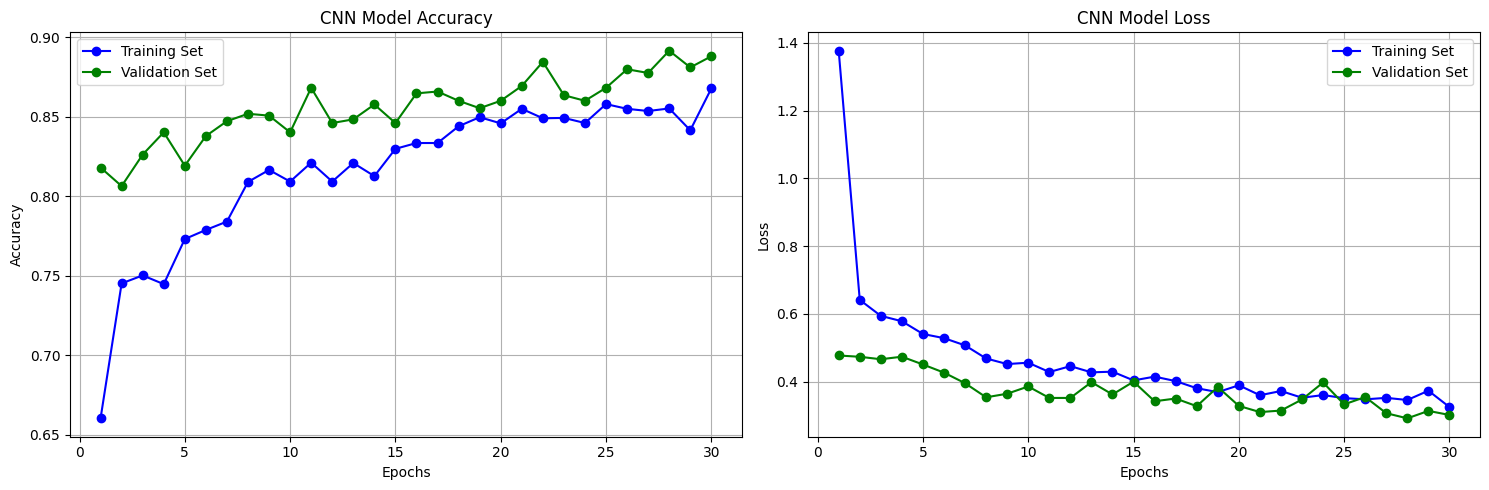

In [ ]:
# Plot model performance with enhanced aesthetics
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_acc, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_loss, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

- The model has fluctuations.

41/41 [==============================] - 1s 27ms/step


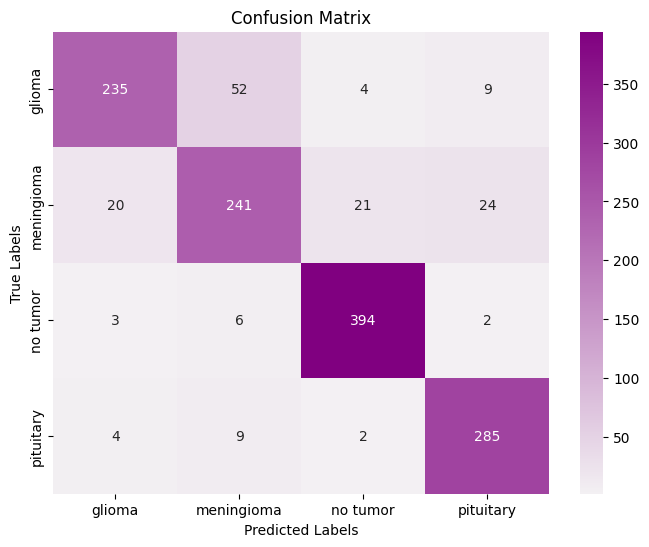

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and X_test, y_test are your test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a colormap
cmap = sns.light_palette("purple", as_cmap=True)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


1. For the "No Tumor" class:
 - True Positives (no tumor predicted as no tumor): 394
 - False Positives (no tumor predicted as other classes): 11 (6 meningioma + 3 glioma)
 - False Negatives (other classes predicted as no tumor): 2 (pituitary)

2. For the "Pituitary" class:
 - True Positives (pituitary predicted as pituitary): 285
 - False Positives (pituitary predicted as other classes): 15 (3 no tumor + 9 meningioma + 3 glioma)
 - False Negatives (other classes predicted as pituitary): 36 (24 meningioma + 3 no tumor + 9 glioma)

3. For the "Meningioma" class:
 - True Positives (meningioma predicted as meningioma): 241
 - False Positives (meningioma predicted as other classes): 34 (24 pituitary + 10 glioma)
 - False Negatives (other classes predicted as meningioma): 41 (21 no tumor + 20 glioma)

4. For the "Glioma" class:

 - True Positives (glioma predicted as glioma): 235
 - False Positives (glioma predicted as other classes): 35 (9 pituitary + 4 no tumor + 22 meningioma)
 - False Negatives (other classes predicted as glioma): 72 (24 meningioma + 3 no tumor + 45 pituitary)